In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.panel.model import PanelOLS
plt.style.use('fivethirtyeight')

In [2]:
#change working dir
os.chdir(r"E:")

In [3]:
#read data as pd dataframe
raw_data=pd.read_csv(r"POP+PRICE(2019-2022) (最终版).csv",encoding='utf-8-sig')
raw_data.head()

,Game Name,Rating,Primary Genres,Genres,Publisher,Developer,Platform,Platform Count,Indie,ESRB,...,2022-03(pop),2022-04(pop),2022-05(pop),2022-06(pop),2022-07(pop),2022-08(pop),2022-09(pop),2022-10(pop),2022-11(pop),2022-12(pop)
0,Dota 2,90,Free to Play,"Action, Strategy",Valve,Valve,"Linux, macOS, Microsoft Windows",3,0,TEEN(13+),...,20666285.0,19797176.0,20047427.0,19542400.0,19521055.0,20751849.0,22446475.0,22284031.0,24584473.0,21676262.0
1,Counter-Strike: Global Offensive,83,Free to Play,Action,Valve,"Valve, Hidden Path Entertainment","Linux, macOS, Microsoft Windows",3,0,Mature(17+),...,27693472.0,26385858.0,26121178.0,25383277.0,26802539.0,29151560.0,29418820.0,30286975.0,29559461.0,28967999.0
2,PUBG: BATTLEGROUNDS,57,Massively Multiplayer,"Action, Adventure",KRAFTON,KRAFTON,Microsoft Windows,1,0,TEEN(13+),...,15037604.0,14378263.0,13128276.0,11296949.0,11157438.0,11625470.0,12275880.0,12583497.0,11735356.0,13726991.0
3,Hogwarts Legacy,92,RPG,"Action, Adventure, RPG",Warner Bros. Games,Avalanche Software,Microsoft Windows,1,0,TEEN(13+),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,New World,70,Massively Multiplayer,"Action, Adventure, Massively Multiplayer",Amazon Games,Amazon Games,Microsoft Windows,1,0,TEEN(13+),...,911900.0,912575.0,711238.0,565915.0,576310.0,690326.0,1060350.0,1509564.0,2853050.0,1713101.0


In [4]:
pd.set_option('float_format', '{:.2f}'.format)

# 生成统计信息
print(raw_data.describe())

       Rating  Platform Count  Indie  Singleplayer  Multiplayer   Coop   
count  380.00          380.00 380.00        380.00       380.00 380.00  \
mean    79.96            3.39   0.35          0.83         0.70   0.53   
std     14.39            1.73   0.48          0.38         0.46   0.50   
min     26.00            1.00   0.00          0.00         0.00   0.00   
25%     73.00            2.00   0.00          1.00         0.00   0.00   
50%     85.00            3.00   0.00          1.00         1.00   1.00   
75%     90.00            4.00   1.00          1.00         1.00   1.00   
max     97.00           10.00   1.00          1.00         1.00   1.00   

       Online-Coop    PVP  2019-01(price)  2019-02(price)  ...  2022-03(pop)   
count       380.00 380.00          235.00          235.00  ...        347.00  \
mean          0.50   0.43           16.90           13.13  ...     637428.27   
std           0.50   0.50           17.41           13.22  ...    2562084.94   
min          

In [36]:
price_data = raw_data.iloc[:,:64]
pop_data = raw_data.iloc[:,[*range(16),*range(64,112)]]

#condition1 = (~price_data['2019-01(price)'].isnull()) & (~(price_data.iloc[:,16:] == 0).any(axis=1))
condition1 =  (~(price_data.iloc[:,16:] == 0).any(axis=1))
price_data = price_data[condition1].reset_index(drop=True)
pop_data = pop_data[condition1].reset_index(drop=True)

pop_data.insert(0,'game_id',np.arange(0,len(pop_data)))
price_data.insert(0,'game_id',np.arange(0,len(price_data)))

In [37]:
(~(price_data.iloc[:,16:] == 0).any(axis=1)).sum()

262

In [38]:
pop_data = pop_data.melt(id_vars=pop_data.columns[:17],var_name="date",value_name="pop")
price_data = price_data.melt(id_vars=price_data.columns[:17],var_name="date",value_name="price")

pop_data['date'] = pop_data['date'].apply(lambda x:x.strip('(pop)'))
pop_data['date'] = pd.to_datetime(pop_data['date'])
price_data['date'] = price_data['date'].apply(lambda x:x.strip('(price)'))
price_data['date'] = pd.to_datetime(price_data['date'])

price_data = price_data.sort_values(by=['game_id','date'])
pop_data = pop_data.sort_values(by=['game_id','date'])

In [39]:
pop_data['price'] = price_data['price']
pop_data['ReleaseDate'] = pd.to_datetime(pop_data['ReleaseDate'])
pop_data['pop_log_diff'] = pop_data.groupby('game_id')['pop'].apply(lambda x: np.log(x).diff()).values
pop_data['pop_log_diff_d1'] = pop_data.groupby('game_id')['pop_log_diff'].apply(lambda x: x.shift(-1)).values
pop_data['price_log_diff'] = pop_data.groupby('game_id')['price'].apply(lambda x: np.log(x).diff()).values
#pop_data['pop_diff'] = pop_data.groupby('game_id')['pop'].apply(lambda x: x.diff()).values
#pop_data['price_diff'] = pop_data.groupby('game_id')['price'].apply(lambda x: x.diff()).values
#pop_data['pop_per_diff'] = pop_data.groupby('game_id')['pop'].apply(lambda x: x.pct_change()).values
#pop_data['price_per_diff'] = pop_data.groupby('game_id')['price'].apply(lambda x: x.pct_change()).values
#pop_data = pop_data[pop_data['date'] != '2019-01-01']
#price_data = price_data[price_data['date'] != '2019-01-01']

In [40]:
pop_data

,game_id,Game Name,Rating,Primary Genres,Genres,Publisher,Developer,Platform,Platform Count,Indie,...,Coop,Online-Coop,PVP,ReleaseDate,date,pop,price,pop_log_diff,pop_log_diff_d1,price_log_diff
0,0,Terraria,97,Adventure,"Action, Adventure, Indie, RPG",Re-Logic,Re-Logic,"Linux, macOS, Microsoft Windows",3,1,...,1,1,1,2011-05-15,2019-01-01,942721.00,4.99,NaN,-0.30,NaN
262,0,Terraria,97,Adventure,"Action, Adventure, Indie, RPG",Re-Logic,Re-Logic,"Linux, macOS, Microsoft Windows",3,1,...,1,1,1,2011-05-15,2019-02-01,697093.00,9.99,-0.30,-0.02,0.69
524,0,Terraria,97,Adventure,"Action, Adventure, Indie, RPG",Re-Logic,Re-Logic,"Linux, macOS, Microsoft Windows",3,1,...,1,1,1,2011-05-15,2019-03-01,680044.00,4.99,-0.02,0.09,-0.69
786,0,Terraria,97,Adventure,"Action, Adventure, Indie, RPG",Re-Logic,Re-Logic,"Linux, macOS, Microsoft Windows",3,1,...,1,1,1,2011-05-15,2019-04-01,746747.00,9.99,0.09,0.05,0.69
1048,0,Terraria,97,Adventure,"Action, Adventure, Indie, RPG",Re-Logic,Re-Logic,"Linux, macOS, Microsoft Windows",3,1,...,1,1,1,2011-05-15,2019-05-01,788708.00,4.99,0.05,0.13,-0.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11527,261,Total War: ATTILA,79,Strategy,"Action, Indie, RPG, Simulation",SEGA,CREATIVE ASSEMBLY,"Microsoft Windows, macOS, Linux",3,1,...,1,1,1,2015-02-17,2022-08-01,77524.00,44.99,-0.03,-0.05,0.00
11789,261,Total War: ATTILA,79,Strategy,"Action, Indie, RPG, Simulation",SEGA,CREATIVE ASSEMBLY,"Microsoft Windows, macOS, Linux",3,1,...,1,1,1,2015-02-17,2022-09-01,74058.00,44.99,-0.05,0.11,0.00
12051,261,Total War: ATTILA,79,Strategy,"Action, Indie, RPG, Simulation",SEGA,CREATIVE ASSEMBLY,"Microsoft Windows, macOS, Linux",3,1,...,1,1,1,2015-02-17,2022-10-01,82526.00,28.11,0.11,-0.10,-0.47
12313,261,Total War: ATTILA,79,Strategy,"Action, Indie, RPG, Simulation",SEGA,CREATIVE ASSEMBLY,"Microsoft Windows, macOS, Linux",3,1,...,1,1,1,2015-02-17,2022-11-01,74981.00,28.11,-0.10,0.07,0.00


In [41]:
policy_date = ['2019-06-01','2019-07-01','2019-11-01','2019-12-01',
              '2020-06-01','2020-07-01','2020-10-01','2020-11-01','2020-12-01',
              '2021-06-01','2021-07-01','2021-11-01','2021-12-01',
              '2022-06-01','2022-07-01','2022-11-01','2022-12-01']

pop_data['policy'] = pop_data['date'].isin(policy_date).astype(int)
pop_data['policy_var'] = pop_data['policy'] * pop_data['price_log_diff']
#Only consider markdown discounts
pop_data['policy_var'] =(pop_data['policy_var'] <=0).astype(int) * pop_data['policy_var']


In [ ]:
sale_date = pd.DataFrame()

In [44]:
for sale_date in policy_date:
    sale_date_ = sale_date.replace('-','_')
    pop_data[f'policy{sale_date_}'] = (pop_data['date'] == sale_date).astype(int)
    pop_data[f'policy{sale_date_}'] = pop_data[f'policy{sale_date_}'] * pop_data['price_log_diff']
    pop_data[f'policy{sale_date_}'] =(pop_data[f'policy{sale_date_}'] <=0).astype(int) * pop_data[f'policy{sale_date_}']

In [45]:
pop_data

,game_id,Game Name,Rating,Primary Genres,Genres,Publisher,Developer,Platform,Platform Count,Indie,...,policy2020_11_01,policy2020_12_01,policy2021_06_01,policy2021_07_01,policy2021_11_01,policy2021_12_01,policy2022_06_01,policy2022_07_01,policy2022_11_01,policy2022_12_01
0,0,Terraria,97,Adventure,"Action, Adventure, Indie, RPG",Re-Logic,Re-Logic,"Linux, macOS, Microsoft Windows",3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262,0,Terraria,97,Adventure,"Action, Adventure, Indie, RPG",Re-Logic,Re-Logic,"Linux, macOS, Microsoft Windows",3,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
524,0,Terraria,97,Adventure,"Action, Adventure, Indie, RPG",Re-Logic,Re-Logic,"Linux, macOS, Microsoft Windows",3,1,...,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00
786,0,Terraria,97,Adventure,"Action, Adventure, Indie, RPG",Re-Logic,Re-Logic,"Linux, macOS, Microsoft Windows",3,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1048,0,Terraria,97,Adventure,"Action, Adventure, Indie, RPG",Re-Logic,Re-Logic,"Linux, macOS, Microsoft Windows",3,1,...,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11527,261,Total War: ATTILA,79,Strategy,"Action, Indie, RPG, Simulation",SEGA,CREATIVE ASSEMBLY,"Microsoft Windows, macOS, Linux",3,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
11789,261,Total War: ATTILA,79,Strategy,"Action, Indie, RPG, Simulation",SEGA,CREATIVE ASSEMBLY,"Microsoft Windows, macOS, Linux",3,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
12051,261,Total War: ATTILA,79,Strategy,"Action, Indie, RPG, Simulation",SEGA,CREATIVE ASSEMBLY,"Microsoft Windows, macOS, Linux",3,1,...,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00
12313,261,Total War: ATTILA,79,Strategy,"Action, Indie, RPG, Simulation",SEGA,CREATIVE ASSEMBLY,"Microsoft Windows, macOS, Linux",3,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [46]:
pop_data = pop_data.set_index(['game_id', 'date']).sort_index(level=[0,1])

In [11]:
pop_data.to_csv('pop_data_panel.csv',encoding='utf-8-sig')
price_data.to_csv('price_data_panel.csv',encoding='utf-8-sig')

In [12]:
game_data = pop_data.groupby('game_id').apply(lambda x:x.iloc[0])

In [13]:
game_data.describe().to_csv('des.csv')

Text(0.5, 1.0, 'price hist')

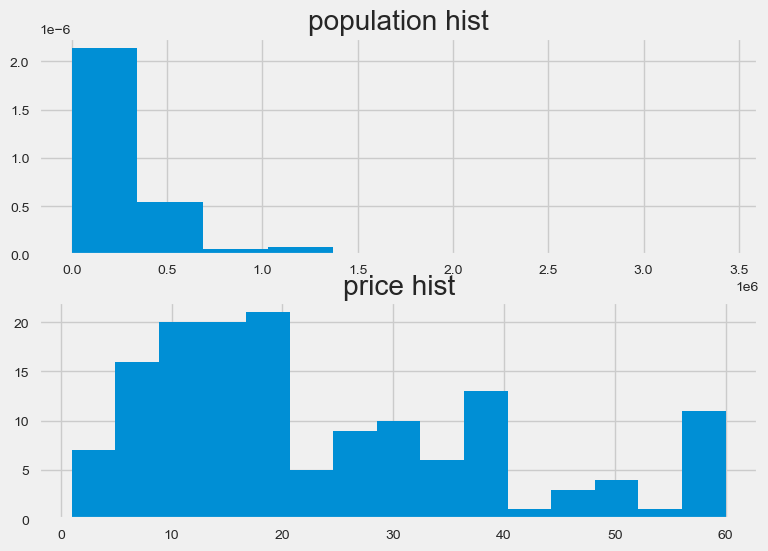

In [332]:
fig,ax = plt.subplots(2)
fig.tight_layout()
ax[0].hist(game_data['pop'],bins=10,density=True)
ax[0].set_title('population hist')
ax[1].hist(game_data['price'],bins=15)
ax[1].set_title('price hist')

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Action'),
  Text(1, 0, 'Adventure'),
  Text(2, 0, 'Strategy'),
  Text(3, 0, 'Simulation'),
  Text(4, 0, 'RPG'),
  Text(5, 0, 'Sports'),
  Text(6, 0, 'Casual'),
  Text(7, 0, 'Massively Multiplayer'),
  Text(8, 0, 'Utilities')])

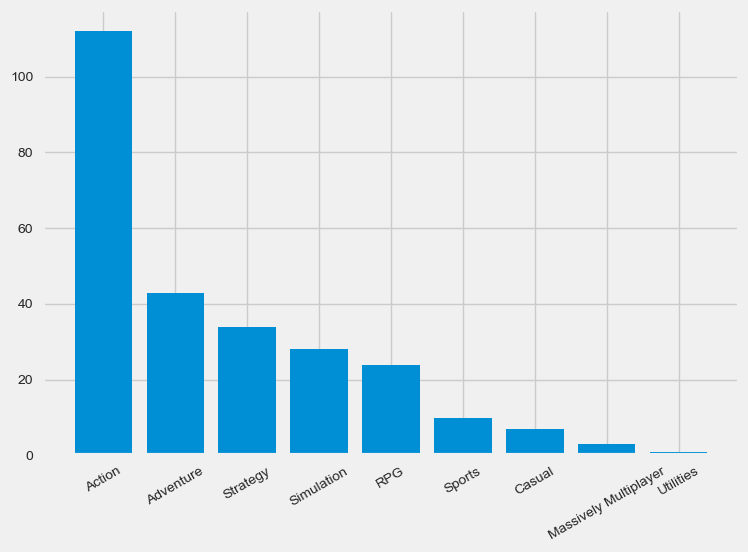

In [333]:
plt.bar(list(game_data['Primary Genres'].value_counts().index),list(game_data['Primary Genres'].value_counts()))
plt.xticks(rotation=30)
print(list(pop_data['Primary Genres'].value_counts()))

In [76]:
Genres_data = pop_data.groupby(['Primary Genres','date']).agg({'price':'mean','pop':'mean'})
Genres_data

price        pop
Primary Genres date                        
Action         2019-01-01  24.10  322245.00
               2019-02-01  17.95  263636.27
               2019-03-01  22.64  285242.41
               2019-04-01  23.23  275002.14
               2019-05-01  23.61  283534.46
...                          ...        ...
Utilities      2022-08-01   2.00 2639731.00
               2022-09-01   2.00 2785230.00
               2022-10-01   2.00 3265135.00
               2022-11-01   2.00 3386275.00
               2022-12-01   2.00 3815314.00

[432 rows x 2 columns]

In [78]:
Genres_data.loc[('Action','2019-01-01')]

price       24.10
pop     322245.00
Name: (Action, 2019-01-01 00:00:00), dtype: float64

In [69]:
Genres_list = list(pop_data['Primary Genres'].value_counts().index)

['Action', 'Adventure', 'Strategy', 'Simulation', 'RPG']

Text(0.5, 1.0, 'Action price')

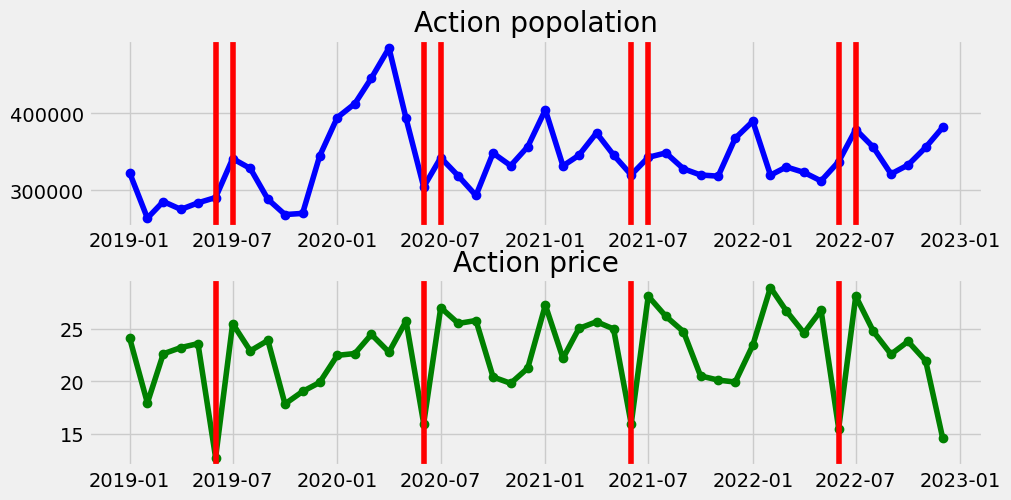

In [88]:
policy_date1 =pd.to_datetime( ['2019-06-01','2020-06-01','2021-06-01','2022-06-01'])
policy_date2 =pd.to_datetime( ['2019-06-01','2020-06-01','2021-06-01','2022-06-01','2019-07-01','2020-07-01','2021-07-01','2022-07-01'])
fig,ax = plt.subplots(2,figsize=(10, 5))
fig.tight_layout()
ax[0].plot(Genres_data.loc[('Action',slice(None))].index,Genres_data.loc[('Action',slice(None)),'pop'].values,'b-o')
#ax[0].tick_params(axis='x',rotation=30)
ax[1].plot(Genres_data.loc[('Action',slice(None))].index,Genres_data.loc[('Action',slice(None)),'price'].values,'g-o')
for policy in policy_date2:
    ax[0].axvline(x=policy,color='red')
for policy in policy_date1:
    ax[1].axvline(x=policy,color='red')
ax[0].set_title('Action popolation')
ax[1].set_title('Action price')

Text(0.5, 1.0, 'Strategy price')

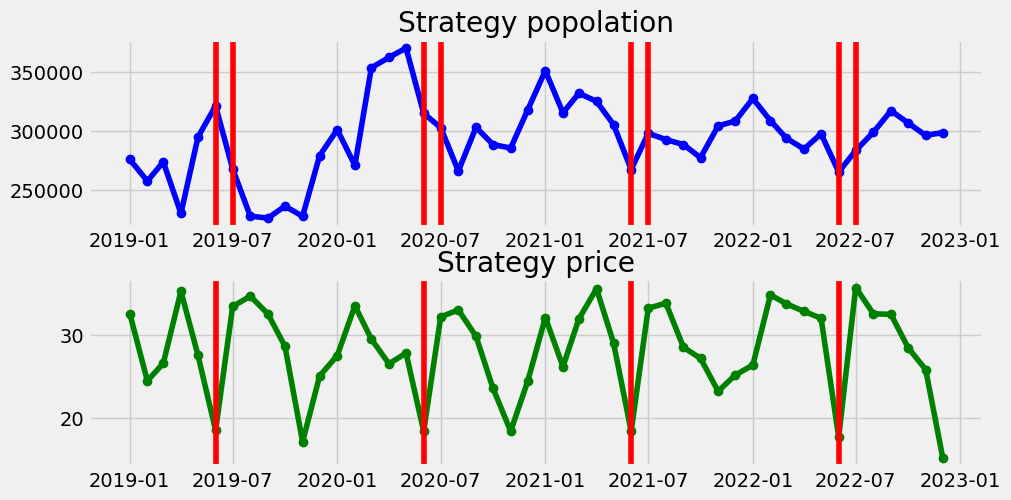

In [92]:
policy_date1 =pd.to_datetime( ['2019-06-01','2020-06-01','2021-06-01','2022-06-01'])
policy_date2 =pd.to_datetime( ['2019-06-01','2020-06-01','2021-06-01','2022-06-01','2019-07-01','2020-07-01','2021-07-01','2022-07-01'])
fig,ax = plt.subplots(2,figsize=(10, 5))
fig.tight_layout()
ax[0].plot(Genres_data.loc[('Action',slice(None))].index,Genres_data.loc[('Strategy',slice(None)),'pop'].values,'b-o')
#ax[0].tick_params(axis='x',rotation=30)
ax[1].plot(Genres_data.loc[('Action',slice(None))].index,Genres_data.loc[('Strategy',slice(None)),'price'].values,'g-o')
for policy in policy_date2:
    ax[0].axvline(x=policy,color='red')
for policy in policy_date1:
    ax[1].axvline(x=policy,color='red')
ax[0].set_title('Strategy popolation')
ax[1].set_title('Strategy price')

Text(0.5, 1.0, 'Adventure price')

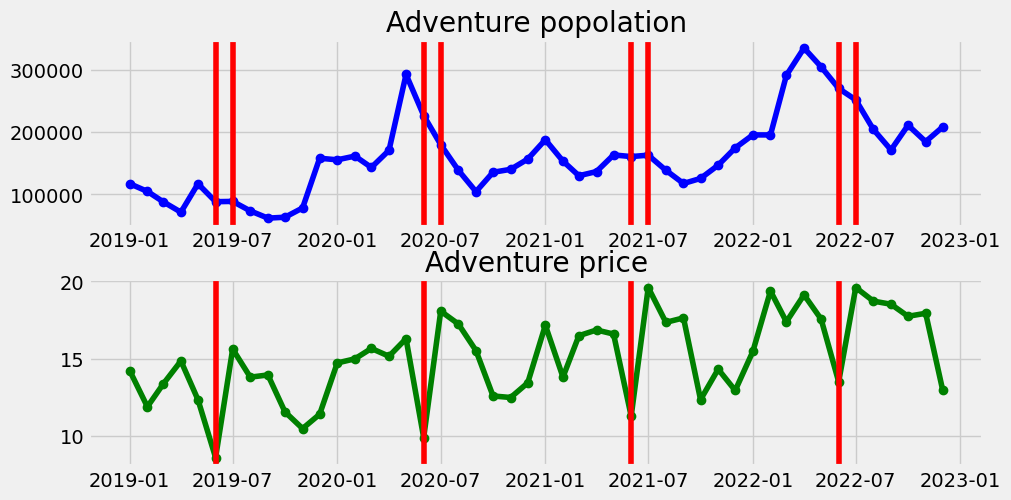

In [93]:
policy_date1 =pd.to_datetime( ['2019-06-01','2020-06-01','2021-06-01','2022-06-01'])
policy_date2 =pd.to_datetime( ['2019-06-01','2020-06-01','2021-06-01','2022-06-01','2019-07-01','2020-07-01','2021-07-01','2022-07-01'])
fig,ax = plt.subplots(2,figsize=(10, 5))
fig.tight_layout()
ax[0].plot(Genres_data.loc[('Action',slice(None))].index,Genres_data.loc[('Adventure',slice(None)),'pop'].values,'b-o')
#ax[0].tick_params(axis='x',rotation=30)
ax[1].plot(Genres_data.loc[('Action',slice(None))].index,Genres_data.loc[('Adventure',slice(None)),'price'].values,'g-o')
for policy in policy_date2:
    ax[0].axvline(x=policy,color='red')
for policy in policy_date1:
    ax[1].axvline(x=policy,color='red')
ax[0].set_title('Adventure popolation')
ax[1].set_title('Adventure price')

Text(0.5, 1.0, 'Monster Hunter: World price')

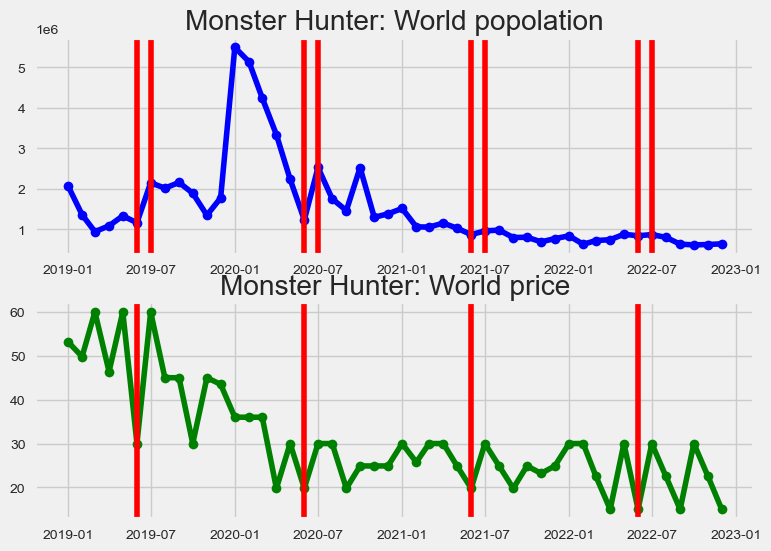

In [338]:
policy_date1 =pd.to_datetime( ['2019-06-01','2020-06-01','2021-06-01','2022-06-01'])
policy_date2 =pd.to_datetime( ['2019-06-01','2020-06-01','2021-06-01','2022-06-01','2019-07-01','2020-07-01','2021-07-01','2022-07-01'])
fig,ax = plt.subplots(2)
fig.tight_layout()
ax[0].plot(pop_data.loc[(4,slice(None))].index,pop_data.loc[(7,slice(None)),'pop'].values,'b-o')
ax[1].plot(pop_data.loc[(4,slice(None))].index,pop_data.loc[(7,slice(None)),'price'].values,'g-o')
for policy in policy_date2:
    ax[0].axvline(x=policy,color='red')
for policy in policy_date1:
    ax[1].axvline(x=policy,color='red')
ax[0].set_title('Monster Hunter: World popolation')
ax[1].set_title('Monster Hunter: World price')

Text(0.5, 1.0, 'pop_log_diff_d1')

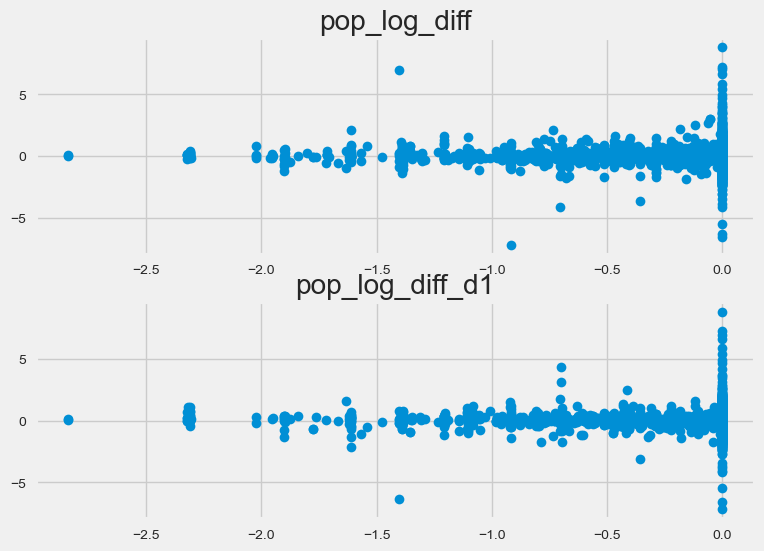

In [339]:
fig,ax = plt.subplots(2)
fig.tight_layout()
ax[0].plot(aa['policy_var'],aa['pop_log_diff'],'o')
ax[0].set_title("pop_log_diff")
ax[1].plot(aa['policy_var'],aa['pop_log_diff_d1'],'o')
ax[1].set_title("pop_log_diff_d1")

In [58]:
'pop_log_diff ~ ' + '+'.join(var_list) + '+ EntityEffects + TimeEffects'

'pop_log_diff ~ policy2019_06_01+policy2019_07_01+policy2019_11_01+policy2019_12_01+policy2020_06_01+policy2020_07_01+policy2020_10_01+policy2020_11_01+policy2020_12_01+policy2021_06_01+policy2021_07_01+policy2021_11_01+policy2021_12_01+policy2022_06_01+policy2022_07_01+policy2022_11_01+policy2022_12_01+ EntityEffects + TimeEffects'

D:\Anaconda3\lib\site-packages\linearmodels\panel\model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
D:\Anaconda3\lib\site-packages\linearmodels\panel\model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                      Model Comparison                      
                               model_DID        model_DID_d1
------------------------------------------------------------
Dep. Variable               pop_log_diff     pop_log_diff_d1
Estimator                       PanelOLS            PanelOLS
No. Observations                    9257                9011
Cov. Est.                      Clustered           Clustered
R-squared                         0.0082              0.0089
R-Squared (Within)                0.0048              0.0116
R-Squared (Between)              -0.0170             -0.0183
R-Squared (Overall)               0.0043              0.0110
F-statistic                       4.3698              4.8902
P-value (F-stat)                  0.0000              0.0000
=====================     ==============   =================
policy2019_06_01                 -0.0800             -0.0429
                                (0.1145)            (0.0638)
policy2019_07_01        

C:\Users\dell\AppData\Local\Temp\ipykernel_15372\2434948600.py:3: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

policy2022_12_01

  model2 = PanelOLS.from_formula('pop_log_diff_d1 ~ ' + '+'.join(var_list) + '+ EntityEffects + TimeEffects',


In [33]:
model1 = PanelOLS.from_formula('pop_log_diff ~  policy_var + EntityEffects + TimeEffects',
                                 data=pop_data).fit(cov_type="clustered", cluster_entity=True)
model2 = PanelOLS.from_formula('pop_log_diff_d1 ~  policy_var + EntityEffects + TimeEffects',
                                 data=pop_data).fit(cov_type="clustered", cluster_entity=True)
from linearmodels.panel.results import compare
model_1_2 = {'model_DID':model1,'model_DID_d1':model2}
print(compare(model_1_2,precision="std_errors",stars=True))

D:\Anaconda3\lib\site-packages\linearmodels\panel\model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
D:\Anaconda3\lib\site-packages\linearmodels\panel\model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                      Model Comparison                      
                               model_DID        model_DID_d1
------------------------------------------------------------
Dep. Variable               pop_log_diff     pop_log_diff_d1
Estimator                       PanelOLS            PanelOLS
No. Observations                    9257                9011
Cov. Est.                      Clustered           Clustered
R-squared                      5.137e-05              0.0002
R-Squared (Within)                0.0001              0.0016
R-Squared (Between)               0.0016             -0.0069
R-Squared (Overall)            6.542e-06              0.0014
F-statistic                       0.4600              1.3166
P-value (F-stat)                  0.4976              0.2512
=====================     ==============   =================
policy_var                       -0.0150             -0.0256
                                (0.0324)            (0.0343)
======================= 

In [ ]:
Genres_models = {}
Genres_list = list(pop_data['Primary Genres'].value_counts().index)
for genre in Genres_list[:5]:
    Genres_models[f'model_{genre}'] = PanelOLS.from_formula('pop_log_diff ~  policy_var + EntityEffects + TimeEffects',
                                 data=pop_data[pop_data['Primary Genres'] == genre]).fit(cov_type="clustered", cluster_entity=True)

print(compare(Genres_models,precision="std_errors",stars=True))

In [281]:
Genres_models = {}
Genres_list = list(pop_data['Primary Genres'].value_counts().index)
for genre in Genres_list[:5]:
    Genres_models[f'model_{genre}'] = PanelOLS.from_formula('pop_log_diff_d1 ~  policy_var + EntityEffects + TimeEffects',
                                 data=pop_data[pop_data['Primary Genres'] == genre]).fit(cov_type="clustered", cluster_entity=True)

print(compare(Genres_models,precision="std_errors",stars=True))

D:\Anaconda3\lib\site-packages\linearmodels\panel\model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
D:\Anaconda3\lib\site-packages\linearmodels\panel\model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
D:\Anaconda3\lib\site-packages\linearmodels\panel\model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                                                      Model Comparison                                                     
                               model_Action     model_Adventure      model_Strategy    model_Simulation           model_RPG
---------------------------------------------------------------------------------------------------------------------------
Dep. Variable               pop_log_diff_d1     pop_log_diff_d1     pop_log_diff_d1     pop_log_diff_d1     pop_log_diff_d1
Estimator                          PanelOLS            PanelOLS            PanelOLS            PanelOLS            PanelOLS
No. Observations                       3968                1311                1256                1060                 812
Cov. Est.                         Clustered           Clustered           Clustered           Clustered           Clustered
R-squared                            0.0001              0.0029              0.0029              0.0008              0.0123
R-Square

D:\Anaconda3\lib\site-packages\linearmodels\panel\model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
D:\Anaconda3\lib\site-packages\linearmodels\panel\model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [64]:
var_list = ["policy"+x.replace('-','_') for x in policy_date[:]]
model1 = PanelOLS.from_formula('pop_log_diff ~ ' + '+'.join(var_list) + '+ EntityEffects + TimeEffects',
                                 data=pop_data,check_rank=False,drop_absorbed=True).fit(cov_type="clustered", cluster_entity=True)
model2 = PanelOLS.from_formula('pop_log_diff_d1 ~ ' + '+'.join(var_list) + '+ EntityEffects + TimeEffects',
                                 data=pop_data,check_rank=False,drop_absorbed=True).fit(cov_type="clustered", cluster_entity=True)
from linearmodels.panel.results import compare
model_1_2 = {'model_DID':model1,'model_DID_d1':model2}
print(compare(model_1_2,precision="std_errors",stars=True))

D:\Anaconda3\lib\site-packages\linearmodels\panel\model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
D:\Anaconda3\lib\site-packages\linearmodels\panel\model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\dell\AppData\Local\Temp\ipykernel_15372\1974017870.py:4: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

policy2022_12_01

  model2 = PanelOLS.from_formula('pop_log_diff_d1 ~ ' + '+'.join(var_list) + '+ EntityEffects + TimeEffects',


                      Model Comparison                      
                               model_DID        model_DID_d1
------------------------------------------------------------
Dep. Variable               pop_log_diff     pop_log_diff_d1
Estimator                       PanelOLS            PanelOLS
No. Observations                    9257                9011
Cov. Est.                      Clustered           Clustered
R-squared                         0.0082              0.0089
R-Squared (Within)                0.0048              0.0116
R-Squared (Between)              -0.0170             -0.0183
R-Squared (Overall)               0.0043              0.0110
F-statistic                       4.3698              4.8902
P-value (F-stat)                  0.0000              0.0000
=====================     ==============   =================
policy2019_06_01                 -0.0800             -0.0429
                                (0.1145)            (0.0638)
policy2019_07_01        

In [65]:
Genres_models = {}
Genres_list = list(pop_data['Primary Genres'].value_counts().index)
print(Genres_list)
for genre in Genres_list[:5]:
    Genres_models[f'model_{genre}'] = PanelOLS.from_formula('pop_log_diff ~ ' + '+'.join(var_list) + '+ EntityEffects + TimeEffects',
                                 data=pop_data[pop_data['Primary Genres'] == genre],check_rank=False,drop_absorbed=True).fit(cov_type="clustered", cluster_entity=True)

print(compare(Genres_models,precision="std_errors",stars=True))

['Action', 'Adventure', 'Strategy', 'Simulation', 'RPG', 'Sports', 'Casual', 'Massively Multiplayer', 'Utilities']


D:\Anaconda3\lib\site-packages\linearmodels\panel\model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
D:\Anaconda3\lib\site-packages\linearmodels\panel\model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
D:\Anaconda3\lib\site-packages\linearmodels\panel\model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\dell\AppData\Local\Temp\ipykernel_15372\1943567788.py:5: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

policy2019_07_01, policy2019_12_01, policy2020_12_01

  Genres_models[f'model_{genre}'] = PanelOLS.from_formula('pop_log_diff ~ ' 

                                              Model Comparison                                              
                            model_Action  model_Adventure   model_Strategy model_Simulation        model_RPG
------------------------------------------------------------------------------------------------------------
Dep. Variable               pop_log_diff     pop_log_diff     pop_log_diff     pop_log_diff     pop_log_diff
Estimator                       PanelOLS         PanelOLS         PanelOLS         PanelOLS         PanelOLS
No. Observations                    4073             1352             1288             1087              833
Cov. Est.                      Clustered        Clustered        Clustered        Clustered        Clustered
R-squared                         0.0238           0.0111           0.0145           0.0130           0.0187
R-Squared (Within)                0.0104           0.0155          -0.0016           0.0225          -0.0131
R-Squared (Between)

C:\Users\dell\AppData\Local\Temp\ipykernel_15372\1943567788.py:5: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

policy2022_07_01

  Genres_models[f'model_{genre}'] = PanelOLS.from_formula('pop_log_diff ~ ' + '+'.join(var_list) + '+ EntityEffects + TimeEffects',


In [91]:
Genres_models = {}
Genres_list = list(pop_data['Primary Genres'].value_counts().index)
print(Genres_list)
for genre in Genres_list[:5]:
    Genres_models[f'model_{genre}'] = PanelOLS.from_formula('pop_log_diff_d1 ~ ' + '+'.join(var_list) + '+ EntityEffects + TimeEffects',
                                 data=pop_data[pop_data['Primary Genres'] == genre],check_rank=False,drop_absorbed=True).fit(cov_type="clustered", cluster_entity=True)

print(compare(Genres_models,precision="std_errors",stars=True))

['Action', 'Adventure', 'Strategy', 'Simulation', 'RPG', 'Sports', 'Casual', 'Massively Multiplayer', 'Utilities']


D:\Anaconda3\lib\site-packages\linearmodels\panel\model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\dell\AppData\Local\Temp\ipykernel_15372\677755051.py:5: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

policy2022_12_01

  Genres_models[f'model_{genre}'] = PanelOLS.from_formula('pop_log_diff_d1 ~ ' + '+'.join(var_list) + '+ EntityEffects + TimeEffects',
D:\Anaconda3\lib\site-packages\linearmodels\panel\model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\dell\AppData\Local\Temp\ipykernel_15372\677755051.py:5: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

policy2022_12_01

  Genres_models[f'model_{genre}

                                                      Model Comparison                                                     
                               model_Action     model_Adventure      model_Strategy    model_Simulation           model_RPG
---------------------------------------------------------------------------------------------------------------------------
Dep. Variable               pop_log_diff_d1     pop_log_diff_d1     pop_log_diff_d1     pop_log_diff_d1     pop_log_diff_d1
Estimator                          PanelOLS            PanelOLS            PanelOLS            PanelOLS            PanelOLS
No. Observations                       3968                1311                1256                1060                 812
Cov. Est.                         Clustered           Clustered           Clustered           Clustered           Clustered
R-squared                            0.0209              0.0151              0.0131              0.0582              0.0213
R-Square

C:\Users\dell\AppData\Local\Temp\ipykernel_15372\677755051.py:5: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

policy2022_07_01, policy2022_12_01

  Genres_models[f'model_{genre}'] = PanelOLS.from_formula('pop_log_diff_d1 ~ ' + '+'.join(var_list) + '+ EntityEffects + TimeEffects',
